In [1]:
using FileIO
using Plots
using Images
using ImageSegmentation

In [465]:
function find_nearest(root, next_level, maxdistance)
    nucleus_distance = [sum(abs.(root .- next_level[i])) for i in 1:length(next_level)]
    mindist, mindist_index = findmin(nucleus_distance);
    if mindist < maxdistance
        return mindist_index
    else
        return nothing
    end
end

function buildtree(root::Int, position)
    tree = []
    height = length(position)
    level = 2
    child = find_nearest(position[1][root], position[level], 100);
    while( child ≠ nothing && level<height)
        push!(tree, child)
        child = find_nearest(position[level][child], position[level+=1], 100)
        #print("$level ")
    end
    tree
end

function generate_path(pos_map)
    all_path = []
    for root in 1:length(pos_map[1])
        tree = buildtree(root, pos_map);
        if length(tree) > 70
            path = [pos_map[i+1][tree[i]] for i in 1:length(tree) ];
            push!(all_path, path)
        end
    end
    all_path;
end

function export_cell(track, imgs)
    height, width = size(imgs[:,:,1]);
    #Acrop_img = zeros(height, width, length(track));
    crop_img = zeros(700, 700, length(track)*20);
    for t in 1:length(track)
        x, y = Int.(floor.(track[t]));
        xmin, xmax, ymin, ymax = x-349 , x+350,  y-349, y+350
        if xmin < 1
            xmax = xmax - xmin + 1
            xmin = 1
        end
        if xmax > 1900
            xmin = xmin - (xmax-1900)
            xmax = 1900
        end
        if ymin < 1
            ymax = ymax - ymin +1
            ymin = 1
        end
        if ymax > 1300
            ymin = ymin - (ymax-1300)
            ymax = 1300
        end
        masked_cell= (data["edge"][:,:,t] .== data["edge"][x, y, t] )
        for i in 1:20
            crop_img[:,:,20*(t-1)+i] =(masked_cell.*raw[:,:,20*(t-1)+i])[xmin:xmax, ymin:ymax]
        end
    end
    crop_img;
end

export_cell (generic function with 1 method)

In [ ]:
raw = load(File(format"TIFF", "../mRNA_confocal_hamamatsu-60X-TIRF/20200316/HE7-11-1-80uw-PWM_1_s2.ome.tiff"));

In [356]:
data = load("mask4stat.jld");

In [357]:
nucleus_pos = [ component_centroids(label_components(data["nucleus"][:,:,i])) for i in 1:size(data["nucleus"])[3] ];

In [374]:
cells = generate_path(nucleus_pos);

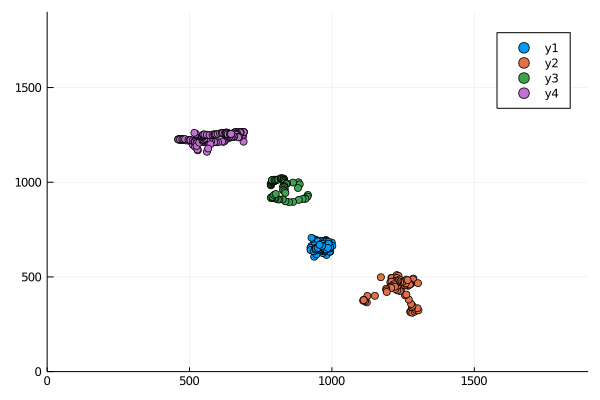

In [380]:
plot( xlim=(0,1900), ylim=(0,1900))
map(i->scatter!(i), cells);
plot!()

In [466]:
for i in 1: length(cells)
    save("path$i.tiff", N0f16.(export_cell(cells[i], raw)))
end

In [393]:
img_export = N0f16.(export_cell(cells[1], raw));

In [439]:
test = img_export[:,:,1] .> 0;
minx = miny = 0;
maxx = maxy = 0;

for y in 1: size(test)[2]
    if (miny==0) && (sum(test[:, y])>0)
        miny = y;
    end
    if (miny > 0) && (sum(test[:, y])==0)
        maxy = y-1;
        break
    end
end

for x in 1: size(test)[1]
    if (minx==0) && (sum(test[x, :])>0)
        minx = x;
    end
    if (minx > 0) && (sum(test[x, :])==0)
        maxx = x-1;
        break
    end
end

In [447]:
save("path1_roi.tiff", N0f16.(export_cell(cells[1], raw))[minx:maxx, miny:maxy, :])